In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read the dataset

In [2]:
df = pd.read_parquet('/content/drive/MyDrive/Project/American Express Default/Dataset/train.parquet')
df_labels = pd.read_csv('/content/drive/MyDrive/Project/American Express Default/Dataset/train_labels.csv')

In [3]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_ID  458913 non-null  object
 1   target       458913 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ MB


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: float32(93), int16(9), int8(86), object(2)
memory usage: 2.5+ GB


In [5]:
df.head(n = 5)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,NaN,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,NaN,0,0.008126,0


## Preliminary Preprocessing

Check rows with missing values

In [6]:
# count missing values in each column
missing_counts = df.isna().sum()

# count non-missing values in each column
non_missing_counts = df.notna().sum()

# calculate total entries in each column
total_counts = missing_counts + non_missing_counts

# calculate percent non-missing for each column
percent_non_missing = non_missing_counts / total_counts * 100

# create a new DataFrame with the results
summary_df = pd.DataFrame({'Missing Count': missing_counts,
                           'Non-Missing Count': non_missing_counts,
                           'Total Count': total_counts,
                           'Percent Non-Missing': percent_non_missing})

Sort from smallest Percent Non-Missing to the largest value

In [7]:
# sort the new DataFrame by Percent Non-Missing from smallest to largest
summary_df_sorted = summary_df.sort_values('Percent Non-Missing')

In [8]:
summary_df_sorted.head(n = 69)

,Missing Count,Non-Missing Count,Total Count,Percent Non-Missing
D_88,5525447,6004,5531451,0.108543
D_110,5500117,31334,5531451,0.566470
B_39,5497819,33632,5531451,0.608014
D_73,5475595,55856,5531451,1.009789
B_42,5459973,71478,5531451,1.292211
...,...,...,...,...
B_40,53,5531398,5531451,99.999042
R_14,1,5531450,5531451,99.999982
R_7,1,5531450,5531451,99.999982
R_20,0,5531451,5531451,100.000000


Drop the columns with percent non-missing $\neq$ 100%

In [9]:
# drop columns with missing values
df_no_missing = df.dropna(axis=1)

In [10]:
df_no_missing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 123 entries, customer_ID to D_145
dtypes: float32(26), int16(9), int8(86), object(2)
memory usage: 1.2+ GB


Check the distribution of the categorical variables

In [11]:
cat = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

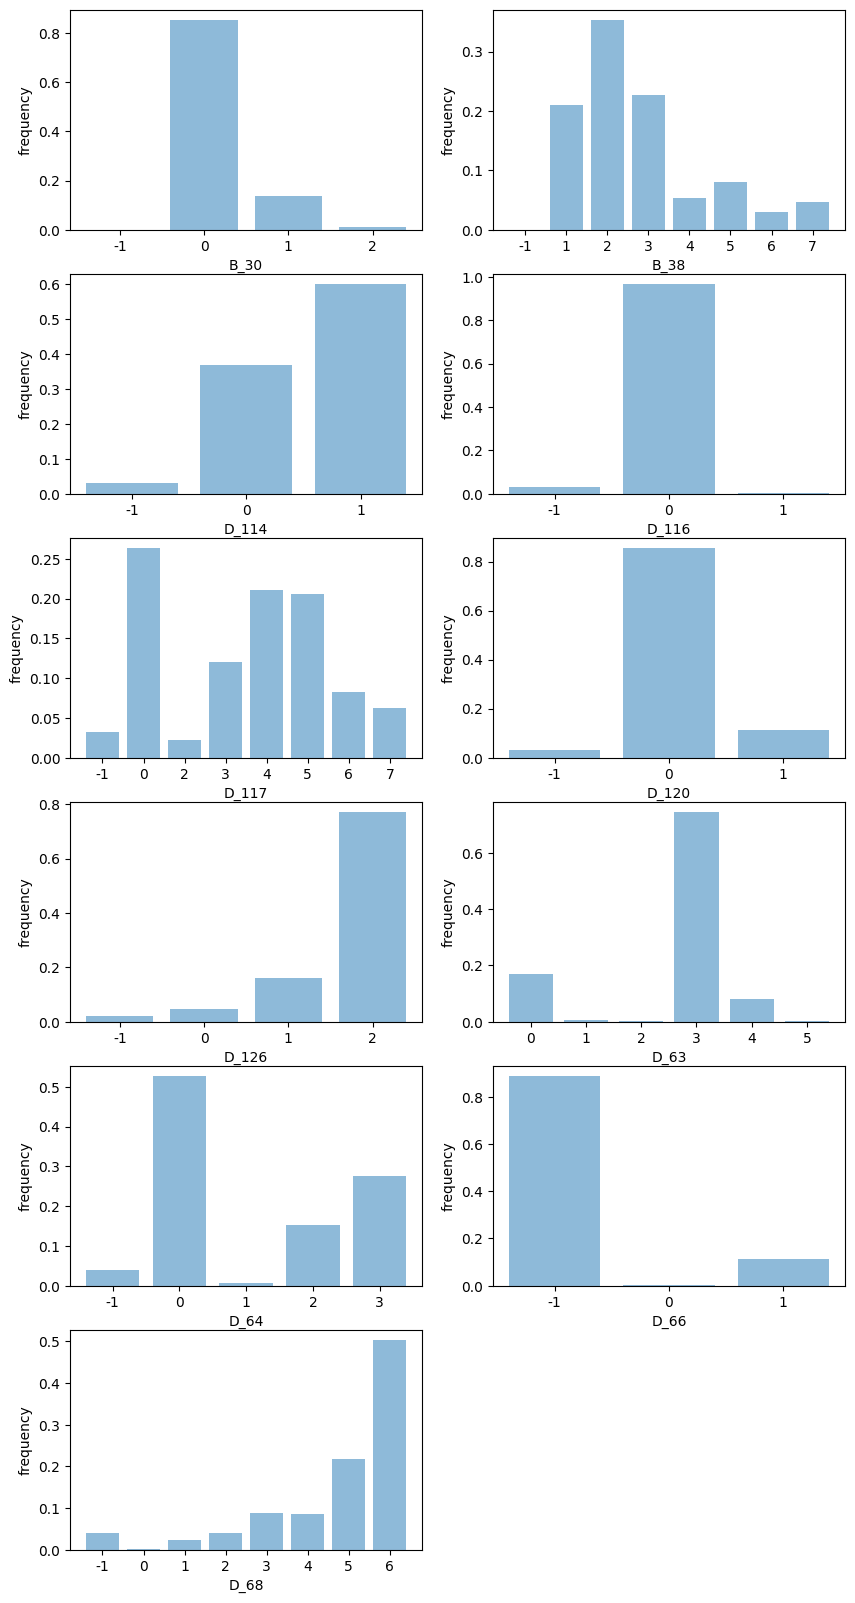

In [12]:
plt.figure(figsize=(10, 20))
for i, k in enumerate(cat):
    plt.subplot(6, 2, i+1)
    temp_val = pd.DataFrame(df_no_missing[k].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp_val.index.name = 'value'
    temp_val.reset_index(inplace=True)
    plt.bar(temp_val.index, temp_val['count'], alpha=0.5)
    plt.xlabel(k)
    plt.ylabel('frequency')
    plt.xticks(temp_val.index, temp_val.value)
plt.show()

**Observations**
1. -1 indicates the missing value present in each of the categorical variables.
2. D_66 has much worse missing values in among all the categorical variables.

S_2 is the date, we can split into year, month and day

In [13]:
# Convert the "Invoice Date" column to a datetime format
df_no_missing["S_2"] = pd.to_datetime(df_no_missing["S_2"],
                                               format="%Y-%m-%d")

# Extract the day, month, and year into separate columns
df_no_missing["Day"] = df_no_missing["S_2"].dt.day
df_no_missing["Month"] = df_no_missing["S_2"].dt.month
df_no_missing["Year"] = df_no_missing["S_2"].dt.year

<ipython-input-13-12438d13ee24>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_missing["S_2"] = pd.to_datetime(df_no_missing["S_2"],
<ipython-input-13-12438d13ee24>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_missing["Day"] = df_no_missing["S_2"].dt.day
<ipython-input-13-12438d13ee24>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [14]:
df_no_missing.head(n = 5)

,customer_ID,S_2,D_39,B_1,R_1,D_44,B_4,B_5,R_2,D_47,...,D_136,D_137,D_138,D_139,D_140,D_143,D_145,Day,Month,Year
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0,0.008724,0.009228,0,6,0.170600,0,0.525351,...,-1,-1,-1,0,0,0,0,9,3,2017
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0,0.004923,0.006151,0,5,0.113239,0,0.521311,...,-1,-1,-1,0,0,0,0,7,4,2017
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,3,0.021655,0.006815,0,5,0.060492,0,0.524568,...,-1,-1,-1,0,0,0,0,28,5,2017
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0,0.013683,0.001373,0,4,0.166782,0,0.530929,...,-1,-1,-1,0,0,0,0,13,6,2017
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0,0.015193,0.007605,0,3,0.143630,0,0.529305,...,-1,-1,-1,0,0,0,0,16,7,2017


Check the number of customer_ID present in the dataset

In [15]:
df_no_missing['customer_ID'].value_counts()

0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a    13
a3111280bfa1ed8fafd0b06839eb707f4538497e8087cb62958bb03e1bdde214    13
a31376930229162f886c091e5a56a528f81c10a523285828ed05a6e9ccf56722    13
a312c595dfaee96c8a597107d2754a49b1acfd127400d98991762d87837b1b65    13
a312aff722e7230f9d6a313ff777d6f00166c6bada21a333982426758a2e2a9d    13
                                                                    ..
a84839802f1f37a86a7fe34ddba4791d33d878df3937b509841def0a9e252748     1
01f4f7b14d83b6a8f88e4355279224615da083b19e3e5f15b98f274ced8cf752     1
eef07ea56302cebcd57374c6565bb3e5c7af856796d9cbc31ed42aa0fc73b7fc     1
d192480082e86e3b4da68f014b284f2a2624b45956eed279416c796de043b7ce     1
d9ea3cffff889b522a69bde89aee382dcff8bffe32c9a38653bdaa2ff4330041     1
Name: customer_ID, Length: 458913, dtype: int64

Investigate this 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a customer_id individual

In [16]:
df_check = df_no_missing[df_no_missing['customer_ID'] == "0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a"]

In [17]:
df_check.head(n = 5)

,customer_ID,S_2,D_39,B_1,R_1,D_44,B_4,B_5,R_2,D_47,...,D_136,D_137,D_138,D_139,D_140,D_143,D_145,Day,Month,Year
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0,0.008724,0.009228,0,6,0.170600,0,0.525351,...,-1,-1,-1,0,0,0,0,9,3,2017
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0,0.004923,0.006151,0,5,0.113239,0,0.521311,...,-1,-1,-1,0,0,0,0,7,4,2017
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,3,0.021655,0.006815,0,5,0.060492,0,0.524568,...,-1,-1,-1,0,0,0,0,28,5,2017
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0,0.013683,0.001373,0,4,0.166782,0,0.530929,...,-1,-1,-1,0,0,0,0,13,6,2017
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0,0.015193,0.007605,0,3,0.143630,0,0.529305,...,-1,-1,-1,0,0,0,0,16,7,2017


In [18]:
#df_check["Year"].value_counts()
df_check["Month"].value_counts()
#df_check["Day"].value_counts()

3     2
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
1     1
2     1
Name: Month, dtype: int64

Inner join the df_no_missing and the df_labels datasets

In [19]:
# merge the two dataframes on the 'customer_ID' key
merged_df = pd.merge(df_no_missing, df_labels, on='customer_ID')

In [20]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Columns: 127 entries, customer_ID to target
dtypes: datetime64[ns](1), float32(26), int16(9), int64(4), int8(86), object(1)
memory usage: 1.4+ GB


In [21]:
merged_df["Year"].value_counts()

2017    4173502
2018    1357949
Name: Year, dtype: int64

## Preliminary EDA

EDA 1) What is the distribution of the monthly defaulter by month in 2017 and 2018?

In [22]:
def time_series_q1(merged_df, year):
  # filter for year 2017 in df based on the 'year' column
  df_year = merged_df[merged_df['Year'] == year]

  # group data by month and calculate the proportion of 1 and 0 from the target column
  df_monthly = df_year.groupby('Month')['target'].value_counts()
  # assuming the data is in a pandas DataFrame called df_monthly
  df_monthly = df_year.groupby('Month')['target'].value_counts(normalize=True).reset_index(name='incidence')

  # Set style and context
  sns.set_style("whitegrid")
  sns.set_context("notebook")

  # Create line plot
  sns.barplot(data=df_monthly, x='Month', y='incidence', hue='target')

  # Set axis labels and title
  plt.xlabel('Month')
  plt.ylabel('Incidence')
  plt.title('Incidence of target 1 and 0 over time')

  # Add legend
  plt.legend(title='Target', loc='upper left')
   

#### 2017

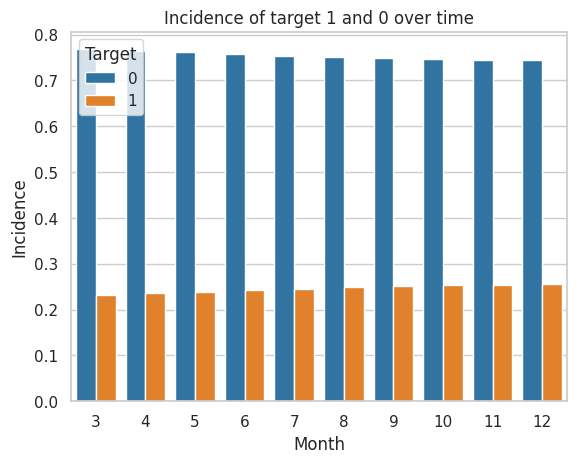

In [23]:
time_series_q1(merged_df, 2017)

#### 2018

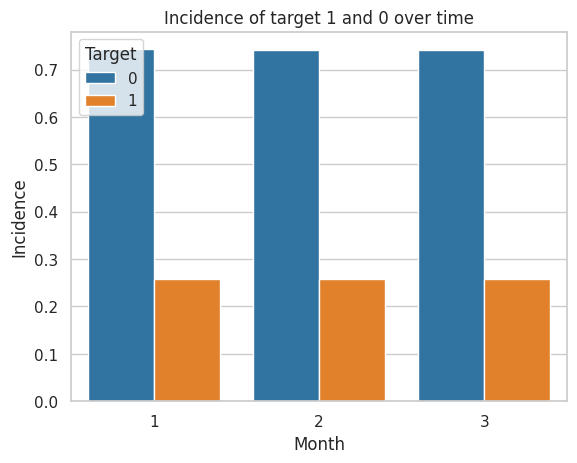

In [24]:
time_series_q1(merged_df, 2018)

## Secondary Preprocessing

Drop the 'S_2' column

In [25]:
df2 = merged_df.drop('S_2', axis=1)

In [26]:
df2.head(n = 5)

,customer_ID,D_39,B_1,R_1,D_44,B_4,B_5,R_2,D_47,D_49,...,D_137,D_138,D_139,D_140,D_143,D_145,Day,Month,Year,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,0.008724,0.009228,0,6,0.170600,0,0.525351,-1,...,-1,-1,0,0,0,0,9,3,2017,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,0.004923,0.006151,0,5,0.113239,0,0.521311,-1,...,-1,-1,0,0,0,0,7,4,2017,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,3,0.021655,0.006815,0,5,0.060492,0,0.524568,-1,...,-1,-1,0,0,0,0,28,5,2017,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,0.013683,0.001373,0,4,0.166782,0,0.530929,-1,...,-1,-1,0,0,0,0,13,6,2017,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,0.015193,0.007605,0,3,0.143630,0,0.529305,-1,...,-1,-1,0,0,0,0,16,7,2017,0


* Some of the customer_id only occur once, and some customer records are recorded multiple times. 
* In particular, information is not provided on when these multiple customers changes from 0 to 1 and vice versa.
* Hence, we will use the last record of each customer as the final values for the model learning.

In [27]:
df2 = df2.sort_values(['Day', 'Month', 'Year'])
df3 = df2.groupby('customer_ID').last()[['Day', 'Month', 'Year']]
df3.head(n = 10)

,Day,Month,Year
customer_ID,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,28,5,2017
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,30,7,2017
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,12,12,2017
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,31,3,2017
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,30,12,2017
000084e5023181993c2e1b665ac88dbb1ce9ef621ec5370150fc2f8bdca6202c,28,4,2017
000098081fde4fd64bc4d503a5d6f86a0aedc425c96f5235f98b0f47c9d7d8d4,22,4,2017
0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4cb59b50fec59e0b6381,26,9,2017
0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85,17,12,2017


We will perform another inner join with the df2 to get the final dataframe

In [28]:
df_final = pd.merge(df3, df2, on=['customer_ID', 'Day', 'Month', 'Year'],
                    how='inner')

In [29]:
df_final.shape

(458913, 126)

Check the distribution of the target column

In [30]:
# count the occurrences of each unique value in the target column
counts = df_labels['target'].value_counts()
counts

0    340085
1    118828
Name: target, dtype: int64

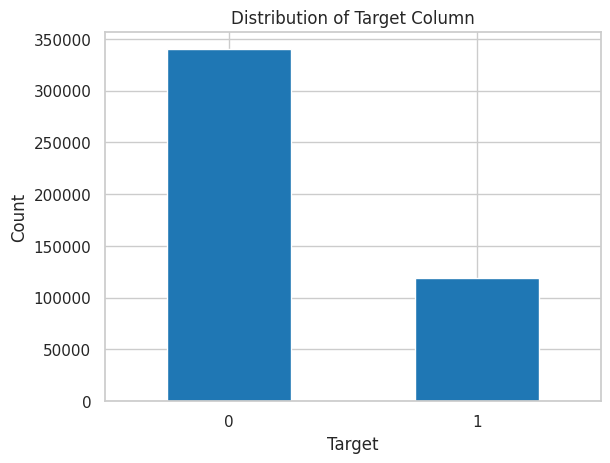

In [31]:
# plot the result using a bar plot and rotate x-axis label vertically
counts.plot(kind='bar')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target Column')
plt.xticks(rotation=360) # set rotation to 90 degrees
plt.show()

## One hot encoding for the categorical variables

In [32]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458913 entries, 0 to 458912
Columns: 126 entries, customer_ID to target
dtypes: float32(26), int16(9), int64(4), int8(86), object(1)
memory usage: 112.0+ MB


In [33]:
categorical_variable = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',
                        'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [34]:
def oneHotEncode(df_final,cat_variable):
  for i in range(0,len(cat_variable)):
    temp_one_hot_encoded = pd.get_dummies(df_final[cat_variable[i]],
                                          prefix = cat_variable[i])
    df_final = pd.concat([df_final,temp_one_hot_encoded], axis = 1)
    # Drop the original column for this i
    df_final.drop(columns=[cat_variable[i]], inplace=True)
  return df_final

In [35]:
df_final1 = oneHotEncode(df_final,categorical_variable)

Drop the customer_id

In [36]:
df_final1.drop(columns=["customer_ID"])

,Day,Month,Year,D_39,B_1,R_1,D_44,B_4,B_5,R_2,...,D_66_0,D_66_1,D_68_-1,D_68_0,D_68_1,D_68_2,D_68_3,D_68_4,D_68_5,D_68_6
0,28,5,2017,3,0.021655,0.006815,0,5,0.060492,0,...,0,0,0,0,0,0,0,0,0,1
1,30,7,2017,11,0.109644,0.008041,0,3,0.029022,0,...,0,0,0,0,0,0,0,0,0,1
2,12,12,2017,0,0.001891,0.006484,0,7,0.004525,0,...,0,0,0,0,0,0,0,0,0,1
3,31,3,2017,9,0.070311,0.004228,0,8,0.000228,0,...,0,0,0,0,0,1,0,0,0,0
4,30,12,2017,0,0.007947,0.003196,0,25,0.002887,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458908,31,3,2018,15,0.028515,0.001928,0,4,0.040532,0,...,0,1,0,0,0,0,0,0,0,1
458909,22,12,2017,1,0.331445,0.000569,1,17,0.019219,0,...,0,0,0,0,0,0,0,0,0,1
458910,23,4,2017,0,0.162431,0.000303,0,3,0.016552,0,...,0,0,0,0,0,0,0,0,1,0
458911,25,8,2017,1,0.019180,0.008340,0,13,0.003248,0,...,0,0,0,0,0,0,0,1,0,0


In [37]:
df_final1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458913 entries, 0 to 458912
Columns: 170 entries, customer_ID to D_68_6
dtypes: float32(26), int16(9), int64(4), int8(75), object(1), uint8(55)
memory usage: 131.3+ MB


## Train-test split the dataset

In [38]:
y = df_final1["target"]

Drop the target from the df_final1 dataset

In [39]:
X = df_final1.drop(columns = ["target"])

In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify = y,
                                                    random_state=42)

Check the target distribution for the y_train

In [41]:
y_train.value_counts()

0    238059
1     83180
Name: target, dtype: int64

Export the datasets

In [42]:
import os

Drop the customer_id in x_train and x_test datasets

In [57]:
x_train = x_train.drop(columns=["customer_ID"])
x_test = x_test.drop(columns=["customer_ID"])

KeyError: ignored

In [59]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321239 entries, 19899 to 231956
Columns: 168 entries, Day to D_68_6
dtypes: float32(26), int16(9), int64(3), int8(75), uint8(55)
memory usage: 87.0 MB


In [58]:
x_train.to_parquet('/content/drive/MyDrive/Project/American Express Default/Dataset/x_train.parquet', index = False)
x_test.to_parquet('/content/drive/MyDrive/Project/American Express Default/Dataset/x_test.parquet', index = False)

In [50]:
# create the Series object
target1 = pd.Series(y_train, name='target')
y_train = pd.DataFrame({'target': target1})
target2 = pd.Series(y_test, name='target')
y_test = pd.DataFrame({'target': target2})

In [55]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321239 entries, 19899 to 231956
Columns: 169 entries, customer_ID to D_68_6
dtypes: float32(26), int16(9), int64(3), int8(75), object(1), uint8(55)
memory usage: 89.5+ MB


In [54]:
y_train.to_csv('/content/drive/MyDrive/Project/American Express Default/Dataset/y_train.csv', index = False)
y_test.to_csv('/content/drive/MyDrive/Project/American Express Default/Dataset/y_test.csv', index = False)